# Gradient Boosting on Decision Trees


Устанавливаем нужные версии библиотек, чтобы версии xgboost и sklearn не противоречили друг другу

In [1]:
!pip uninstall xgboost
!pip install xgboost==1.6.0
!pip uninstall scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/xgboost-2.1.3.dist-info/*
    /usr/local/lib/python3.11/dist-packages/xgboost.libs/libgomp-24e2ab19.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/xgboost/*
Proceed (Y/n)? Y
  Successfully uninstalled xgboost-2.1.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 MB 4.3 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/scikit_learn-1.6.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/sklearn/*
Proceed (Y/n)? Y
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 88.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This 

Устанвливаем catboost

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00


Подключаем используемые библиотеки

In [3]:
from sklearn.datasets import fetch_covtype
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import sklearn
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import log_loss, accuracy_score
import catboost
from catboost import CatBoostClassifier

Загружаем датасет из стандартной библиотеки sklearn (по типам почв)

In [4]:
fetch = fetch_covtype()
df = pd.DataFrame(fetch.data[:50_000], columns=fetch.feature_names)
df['target'] = fetch.target[:50_000]

df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,target
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


Уникальные таргеты

In [5]:
targets = df['target'].unique()
targets

array([5, 2, 1, 7, 3, 6, 4], dtype=int32)

Функция отрисовки распределения данных

In [6]:
def is_data_balanced(df, target_name):
  data_plt = pd.DataFrame(df[target_name].value_counts())
  x = data_plt.index.to_list()
  y = data_plt["count"].to_list()
  fig, ax = plt.subplots()
  pps = ax.bar(x, y, color='lightskyblue', edgecolor='black')
  for p in pps:
    height = round(p.get_height() / sum(y), 2)
    ax.text(x=p.get_x() + p.get_width() / 2, y=p.get_height()/2,
        s="{}%".format(round(height * 100, 2)),
        ha='center')
  plt.xticks(sorted(x), sorted(x), rotation=0)
  plt.show()

Распределение по таргету

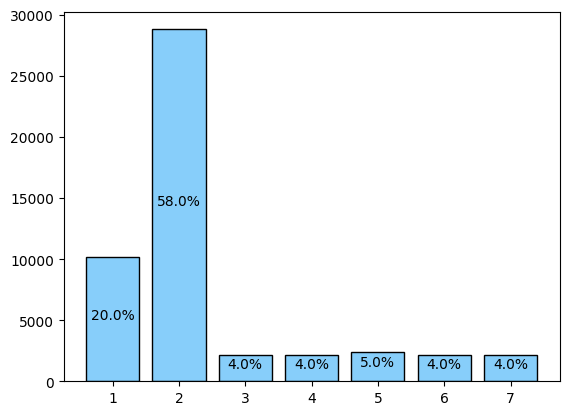

In [7]:
is_data_balanced(df, 'target')

Данные несбалансированы, это важно учесть при построении модели.

In [8]:
df.isnull().sum().sum()

0

Нет пустых значений. (но, вобще говоря, GBDT умеет обрабатывать пропущенные значения)

Деревья устойчивы к выбросам, поскольку разбиения зависят от порогов, которые минимизируеют неоднородность, считаем, что количество выбросов мало => они не сильно влияют на порог (а их абсолютное значение и вовсе не учитывается).

In [9]:
X = df.drop('target', axis=1)
y = df['target'] - 1 # таргеты должны быть в диапазоне (0, n) - особенность xgboost

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
eval_set = [(X_val, y_val)] # валидационная выборка

Поскольку данные несбалансированны (на самом деле данный срез имеет лишь один доминирующий класс, но есть взять исходный датасет, то там заметный дисбаланс, который необходимо регулировать), могут возникнуть большие по модулю антиградиенты, поэтому ограничиваем изменение, которое может происходить на одном шаге обучения, параметром max_delta_step.

In [10]:
# веса классов
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(zip(np.unique(y_train), class_weights))

# генерируем веса для каждого образца на основе классов
sample_weights = np.array([class_weights_dict[class_label] for class_label in y_train])

# XGBoost

In [11]:
xgmodel = XGBClassifier(
    n_estimators=700, # число деревьев
    max_depth=2, # глубина деревьев
    learning_rate=0.1, # темп обучения
    objective='multi:softprob', # лосс функция для многоклассовой задачи
    # метрика оценки на валидации - лог лосс по умолчанию
    early_stopping_rounds=10, # ранняя остановка
    min_child_weight=10, # минимальное число объектов в листе
    random_seed=42, # для воспроизводимости
    # class_weight=class_weights_dict # веса классов
)

xgmodel.fit(
    X_train, y_train,
    eval_set=eval_set,
    sample_weight=sample_weights,  # Передаем веса образцов
    verbose=True
)

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


[20:45:46] WARNING: ../src/learner.cc:627: 
Parameters: { "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.79055
[1]	validation_0-mlogloss:1.66895
[2]	validation_0-mlogloss:1.57258
[3]	validation_0-mlogloss:1.49086
[4]	validation_0-mlogloss:1.42099
[5]	validation_0-mlogloss:1.35968
[6]	validation_0-mlogloss:1.30354
[7]	validation_0-mlogloss:1.25385
[8]	validation_0-mlogloss:1.21017
[9]	validation_0-mlogloss:1.16958
[10]	validation_0-mlogloss:1.13159
[11]	validation_0-mlogloss:1.09742
[12]	validation_0-mlogloss:1.06673
[13]	validation_0-mlogloss:1.03829
[14]	validation_0-mlogloss:1.01519
[15]	validation_0-mlogloss:0.98800
[16]	validation_0-mlogloss:0.96765
[17]	validation_0-mlogloss:0.94502
[18]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=10,
              missing=nan, monotone_constraints='()', n_estimators=700,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_seed=42, random_state=0, ...)

В каждой строке выводится метрика лог-лосс (так как она дефолтная для многоклассовой классификации) на интерации, указанной в []. Мы хотим, чтобы на каждой итерации метрика уменьшалась (иначе сработает преждевременное окончание обучения из-за параметра early_stopping_rounds=10).

Функция вывода метрик (лог лосс и точность)

In [12]:
def model_metrics(model, X_train, y_train, X_test, y_test):
  train_preds = model.predict(X_train)
  train_probs = model.predict_proba(X_train)
  train_log_loss = log_loss(y_train, train_probs)
  train_acc = accuracy_score(y_train, train_preds)

  test_preds = model.predict(X_test)
  test_probs = model.predict_proba(X_test)
  test_log_loss = log_loss(y_test, test_probs)
  test_acc = accuracy_score(y_test, test_preds)

  print(f"Train Log Loss: {train_log_loss }")
  print(f"Test Log Loss: {test_log_loss}")
  print(f"Train Accuracy: {train_acc}")
  print(f"Test Accuracy: {test_acc}")

In [13]:
model_metrics(xgmodel, X_train, y_train, X_test, y_test)

Train Log Loss: 0.3205199692332348
Test Log Loss: 0.34972313931225557
Train Accuracy: 0.8878857142857143
Test Accuracy: 0.874


Параметры подобраны таким образом, чтобы модель достигла наилучших метрик, но при этом не переобучилась.

# CatBoost

Запустим модель с теми же параметрами

In [14]:
catmodel = CatBoostClassifier(
    iterations=700,             # число деревьев
    depth=2,                    # глубина деревьев
    learning_rate=0.1,          # темп обучения
    loss_function='MultiClass', # лосс функция для многоклассовой задачи
    eval_metric='MultiClass',   # метрика оценки на валидации
    min_data_in_leaf=10,        # минимальное число объектов в листе
    # class_weights=list(class_weights_dict.values()),  # веса классов
    early_stopping_rounds=10,   # ранняя остановка
    random_seed=42,             # для воспроизводимости
)

catmodel.fit(
    X_train, y_train,
    eval_set=eval_set,
    sample_weight=sample_weights,  # Передаем веса образцов
    verbose=True
)

0:	learn: 1.8051767	test: 1.7953805	best: 1.7953805 (0)	total: 71.1ms	remaining: 49.7s
1:	learn: 1.7037617	test: 1.7212059	best: 1.7212059 (1)	total: 93.6ms	remaining: 32.7s
2:	learn: 1.6256589	test: 1.6610462	best: 1.6610462 (2)	total: 115ms	remaining: 26.8s
3:	learn: 1.5437456	test: 1.5570342	best: 1.5570342 (3)	total: 138ms	remaining: 24.1s
4:	learn: 1.4759888	test: 1.4794420	best: 1.4794420 (4)	total: 162ms	remaining: 22.5s
5:	learn: 1.4150563	test: 1.3952150	best: 1.3952150 (5)	total: 190ms	remaining: 21.9s
6:	learn: 1.3642929	test: 1.3205200	best: 1.3205200 (6)	total: 212ms	remaining: 21s
7:	learn: 1.3248235	test: 1.2966010	best: 1.2966010 (7)	total: 233ms	remaining: 20.2s
8:	learn: 1.2846966	test: 1.2691814	best: 1.2691814 (8)	total: 257ms	remaining: 19.7s
9:	learn: 1.2501646	test: 1.2510979	best: 1.2510979 (9)	total: 281ms	remaining: 19.4s
10:	learn: 1.2201288	test: 1.2184784	best: 1.2184784 (10)	total: 303ms	remaining: 19s
11:	learn: 1.1907113	test: 1.2020175	best: 1.2020175 (

In [15]:
model_metrics(catmodel, X_train, y_train, X_test, y_test)

Train Log Loss: 0.4472803999891677
Test Log Loss: 0.46076338192447996
Train Accuracy: 0.8468571428571429
Test Accuracy: 0.8381333333333333


Подберем параметры для этой модели

In [20]:
catmodel = CatBoostClassifier(
    iterations=1000,             # число деревьев
    depth=3,                    # глубина деревьев
    learning_rate=0.12,          # темп обучения
    loss_function='MultiClass', # лосс функция для многоклассовой задачи
    eval_metric='MultiClass',   # метрика оценки на валидации
    min_data_in_leaf=10,        # минимальное число объектов в листе
    # class_weights=list(class_weights_dict.values()),  # веса классов
    early_stopping_rounds=10,   # ранняя остановка
    random_seed=42,             # для воспроизводимости
)

catmodel.fit(
    X_train, y_train,
    eval_set=eval_set,
    sample_weight=sample_weights,  # Передаем веса образцов
    verbose=False
)

In [21]:
model_metrics(catmodel, X_train, y_train, X_test, y_test)

Train Log Loss: 0.3291594775317349
Test Log Loss: 0.3540049224679061
Train Accuracy: 0.8862571428571429
Test Accuracy: 0.87


В нашем случае модели дают близкие значения метрик. Однако релизация градиентного бутинга и построения деревьев в частности отличаются в рассматриваемых библиотеках. \
XGBoost и CatBoost с предполагает разный метод построения деревьев: в первом строятся ассимметричные деревья, а во второй симметричные деревья. \
CatBoost часто имеет более низкий логлосс из-за симметричной структуры деревьев, которые предотвращают переобучение. \
XGBoost может давать более высокий логлосс, если модель переобучается из-за агрессивного поиска разбиений. Как следствие, эта модель требует более тщательного подбора гиперпараметров. \
Еще фреймворки отличаются тем, что XGBoost хуже работает с категориальными данными. CatBoost предпочтителен для работы с данными с сильным дисбалансом.
